#**Vehicle Detection And Counting using Video and Images.**  

# **What is this project about?**

In vehicle detection and counting, I had use a video and Image to recognize vehicles and count the number of each type of vehicle.

# **What is YOLO v3?**
YOLO stands for You Only Look Once. It is a real-time object recognition algorithm. It can classify and localize multiple objects in a single frame. YOLO is a very fast and accurate algorithm for its simpler network architecture.


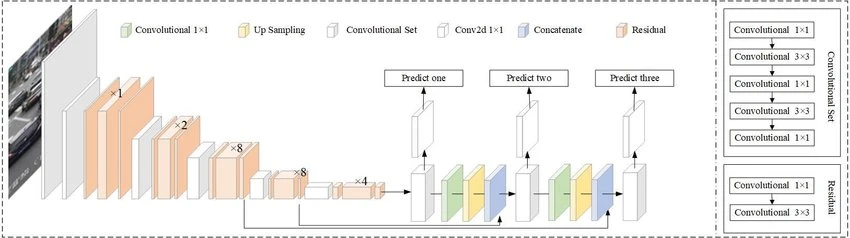

* The YOLO network has 24 convolutional layers followed by 2 fully 
connected layers. 
* The convolutional layers are pre-trained on the ImageNet classification task at half the resolution (224 × 224 input image) and then double the resolution for detection.
* The layers Alternating 1 × 1 reduction layer and 3×3 convolutional layer to reduce the feature space from preceding layers.
* The last 4 layers are added to train the network for object detection.
* The last layer predicts the object class probability and the bounding box probability.

**What All you will need for this project:**
1. Python – 3.x 
2. OpenCV – 4.4.0
You can install OpenCV via “pip install opencv-python opencv_contrib-python”.
3. Numpy – 1.20.3
4. YOLOv3 Pre-trained model weights and Config Files.

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80
Counter({'car': 19, 'truck': 5, 'bus': 1})


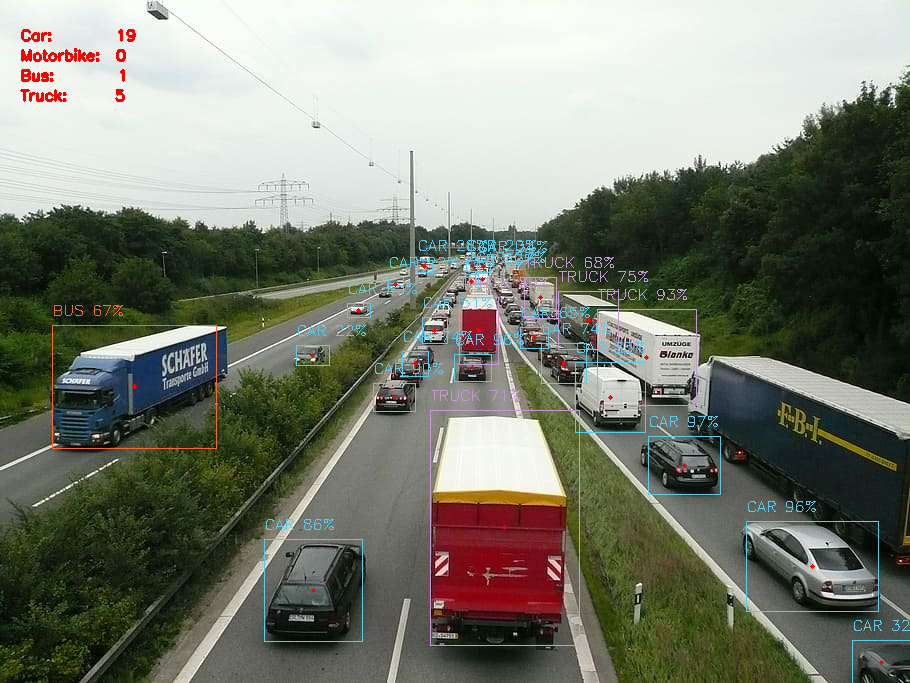

In [ ]:
# Import necessary packages
import cv2
import csv
import collections
import numpy as np
from tracker import *
from google.colab.patches import cv2_imshow #To run cv in google colab

# Initialize Tracker
tracker = EuclideanDistTracker() #The tracker basically uses the Euclidean_distance concept to keep track of an object. 

# Initialize the videocapture object
cap = cv2.VideoCapture('/content/production ID_3727445.mp4')   #Importing the video file 
input_size = 320

#For detection and Non-Max suppression threshold respectively.
confThreshold =0.2
nmsThreshold= 0.2

font_color = (0, 0, 255)
font_size = 0.5
font_thickness = 2

# Middle cross line position that will be used to count vehicles.
middle_line_position = 225   
up_line_position = middle_line_position - 15
down_line_position = middle_line_position + 15


# Store Coco Names in a list
classesFile = "coco.names"
classNames = open(classesFile).read().strip().split('\n')
print(classNames)
print(len(classNames))

# class index for our required detection classes
required_class_index = [2, 3, 5, 7]

detected_classNames = []

## Model Files
modelConfiguration = 'yolov3-320.cfg'
modelWeigheights = 'yolov3-320.weights'

# configure the network model
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeigheights)

# Define random colour for each class
np.random.seed(42) #saves the state of a random function
colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8') #generate a random color for each class in our dataset

# Function for finding the center of a rectangle
def find_center(x, y, w, h):
    x1=int(w/2)
    y1=int(h/2)
    cx = x+x1
    cy=y+y1
    return cx, cy
    
# List for store vehicle count information
temp_up_list = []
temp_down_list = []
up_list = [0, 0, 0, 0]
down_list = [0, 0, 0, 0]

# Function for count vehicle
def count_vehicle(box_id, img):

    x, y, w, h, id, index = box_id

    # Find the center of the rectangle for detection
    center = find_center(x, y, w, h)
    ix, iy = center
    
    # Find the current position of the vehicle
    if (iy > up_line_position) and (iy < middle_line_position):

        if id not in temp_up_list:
            temp_up_list.append(id)

    elif iy < down_line_position and iy > middle_line_position:
        if id not in temp_down_list:
            temp_down_list.append(id)
            
    elif iy < up_line_position:
        if id in temp_down_list:
            temp_down_list.remove(id)
            up_list[index] = up_list[index]+1

    elif iy > down_line_position:
        if id in temp_up_list:
            temp_up_list.remove(id)
            down_list[index] = down_list[index] + 1

    # Draw circle in the middle of the rectangle
    cv2.circle(img, center, 2, (0, 0, 255), -1)  # end here
    # print(up_list, down_list)

# Function for finding the detected objects from the network output
def postProcess(outputs,img):
    global detected_classNames 
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    detection = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_index:
                if confidence > confThreshold:
                    # print(classId)
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, confThreshold, nmsThreshold) #reduce the number of boxes and take only the best detection box for the class
    # print(classIds)
    for i in indices.flatten():
        x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        # print(x,y,w,h)

        color = [int(c) for c in colors[classIds[i]]]
        name = classNames[classIds[i]]
        detected_classNames.append(name)
        # Draw classname and confidence score 
        cv2.putText(img,f'{name.upper()} {int(confidence_scores[i]*100)}%',
                  (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Draw bounding rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1) 
        detection.append([x, y, w, h, required_class_index.index(classIds[i])])

    # Update the tracker for each object
    boxes_ids = tracker.update(detection)
    for box_id in boxes_ids:
        count_vehicle(box_id, img)


def realTime():
    while True:
        success, img = cap.read()
        img = cv2.resize(img,(0,0),None,0.5,0.5)
        ih, iw, channels = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

        # Set the input of the network
        net.setInput(blob)
        layersNames = net.getLayerNames()
        outputNames = [(layersNames[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
        # Feed data to the network
        outputs = net.forward(outputNames)
    
        # Find the objects from the network output
        postProcess(outputs,img)

        # Draw the crossing lines
        cv2.line(img, (0, middle_line_position), (iw, middle_line_position), (255, 0, 255), 2)
        cv2.line(img, (0, up_line_position), (iw, up_line_position), (0, 0, 255), 2)
        cv2.line(img, (0, down_line_position), (iw, down_line_position), (0, 0, 255), 2)

        # Draw counting texts in the frame
        cv2.putText(img, "Up", (110, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Down", (160, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Car:        "+str(up_list[0])+"     "+ str(down_list[0]), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Motorbike:  "+str(up_list[1])+"     "+ str(down_list[1]), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Bus:        "+str(up_list[2])+"     "+ str(down_list[2]), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Truck:      "+str(up_list[3])+"     "+ str(down_list[3]), (20, 100), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)

        # Show the frames
        cv2_imshow(img)

        if cv2.waitKey(1) == ord('q'):
            break

    # Write the vehicle counting information in a file and save it

    with open("data.csv", 'w') as f1:
        cwriter = csv.writer(f1)
        cwriter.writerow(['Direction', 'car', 'motorbike', 'bus', 'truck'])
        up_list.insert(0, "Up")
        down_list.insert(0, "Down")
        cwriter.writerow(up_list)
        cwriter.writerow(down_list)
    f1.close()
    # print("Data saved at 'data.csv'")
    # Finally realese the capture object and destroy all active windows
    cap.release()
    cv2.destroyAllWindows()


image_file = '/content/highway-pkw-truck-traffic.jpg'
def from_static_image(image):
    img = cv2.imread(image)

    blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False) #takes an image as input and returns a resized and normalized blob object

    # Set the input of the network
    net.setInput(blob)
    layersNames = net.getLayerNames()
    outputNames = [(layersNames[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
    # Feed data to the network
    outputs = net.forward(outputNames) # to feed the image to the network

    # Find the objects from the network output
    postProcess(outputs,img)

    # count the frequency of detected classes
    frequency = collections.Counter(detected_classNames)
    print(frequency)
    # Draw counting texts in the frame
    cv2.putText(img, "Car:        "+str(frequency['car']), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
    cv2.putText(img, "Motorbike:  "+str(frequency['motorbike']), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
    cv2.putText(img, "Bus:        "+str(frequency['bus']), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
    cv2.putText(img, "Truck:      "+str(frequency['truck']), (20, 100), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)


    cv2_imshow(img)

    cv2.waitKey(0)

    # save the data to a csv file
    with open("static-data.csv", 'a') as f1:
        cwriter = csv.writer(f1)
        cwriter.writerow([image, frequency['car'], frequency['motorbike'], frequency['bus'], frequency['truck']])
    f1.close()


if __name__ == '__main__':
    # realTime()
    from_static_image(image_file)

# **Conlusion:**
In this way, I have implemented an object detection for vehicle detection and counting using Video and Images. The wrong prediction was obtained for a truck which was identified as bus with an accuracy of 67%. 

#**References:**
1) https://arxiv.org/abs/1506.02640 — -> paper for YOLO

2) Andrew NG’s YouTube video for YOLO Object Detection

3) Understanding YOLO and implementing YOLOv3 for Object  Detection-https://medium.com/@sairajneelam?p=5f1f748cc63a

4) https://docs.opencv.org/3.4/d6/d0f/group__dnn.html